LightGBM реализует модель градиентного бустинга над деревьями решений, но ключевые оптимизации делают его гораздо быстрее и эффективнее:

LightGBM (Light Gradient Boosting Machine) — реализация градиентного бустинга от компании Microsoft, способная обрабатывать большие наборы данных и при этом обеспечивать высокую точность. Рассмотрим более подробно ключевые особенности, которые на это повлияли.

# Главные отличия
## A. Leaf-wise (бинарное дерево) вместо Level-wise
* Классический бустинг (и XGBoost по умолчанию) строит дерево уровень за уровнем (level-wise) — сперва все узлы уровня 1, потом уровень 2 и т.д.
* LightGBM строит дерево по листьям (leaf-wise) — выбирает тот лист, в котором уменьшение loss будет максимальным, и делит только его.
    ###  Это даёт:
    * Лучшую минимизацию ошибки.
    * Более глубокие деревья.
    * Лучше работает на больших и сложноразделимых данных.
    * Но может переобучаться, если не ограничивать max_depth или num_leaves.
 
## B. Gradient-based One-Side Sampling (GOSS)
* В градиентном бустинге обучение идёт на всех точках, LightGBM использует частичную выборку:
    * Сохраняет большие градиенты (важные примеры).
    * Случайно выбирает небольшую часть с малыми градиентами.
* Это ускоряет обучение и сохраняет точность.

## C. Exclusive Feature Bundling (EFB)
* Для разреженных фичей (например, one-hot) LightGBM объединяет фичи, которые никогда не активны одновременно.
* Превращает k разреженных признаков в 1 более плотный.
* Это снижает размерность и ускоряет вычисления, не теряя информации.

## D. Гистограммный метод обучения
* Вместо работы с float-числами напрямую:
    * Значения фичей дискретизируются (binned) в фиксированное количество корзин (например, 255).
* Строит дерево на этих гистограммах, что сильно экономит память и ускоряет сортировки.

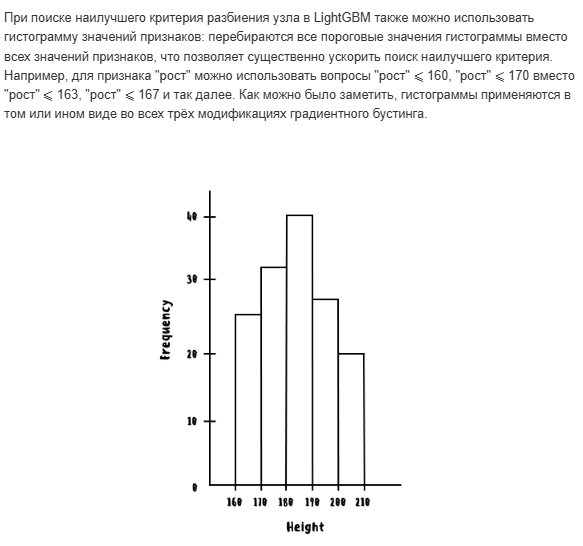

In [2]:
from IPython.display import Image
Image('hist.png')

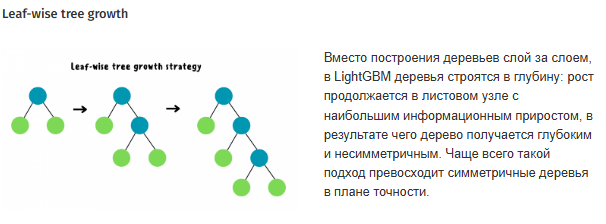

In [4]:
Image('leaf.png')

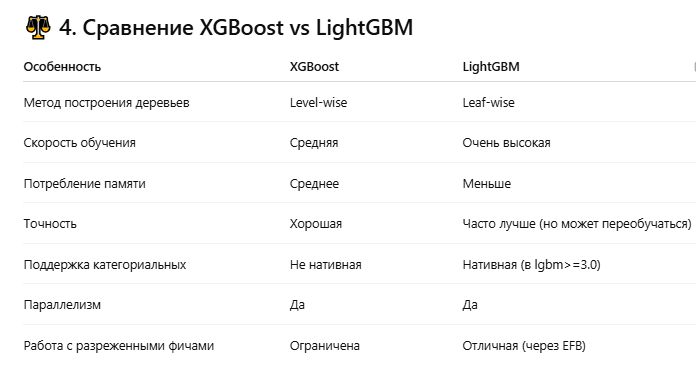

In [3]:
Image('compare.png')

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier


class LightGBMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _gradient(self, y_true, y_pred):
        prob = self._sigmoid(y_pred)
        return prob - y_true

    def _hessian(self, y_true, y_pred):
        prob = self._sigmoid(y_pred)
        return prob * (1 - prob)

    def fit(self, X, y):
        self.trees = []
        y_pred = np.zeros_like(y, dtype=float)

        for i in range(self.n_estimators):
            grad = self._gradient(y, y_pred)
            hess = self._hessian(y, y_pred)

            # целевая переменная для регрессора
            target = -grad / (hess + 1e-10)

            # leaf-wise рост все еще моделируется обычным регрессором с max_depth
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, target)
            update = tree.predict(X)

            y_pred += self.learning_rate * update
            self.trees.append(tree)

    def predict_proba(self, X):
        pred = np.zeros(X.shape[0])
        for tree in self.trees:
            pred += self.learning_rate * tree.predict(X)
        prob = self._sigmoid(pred)
        return np.vstack([1 - prob, prob]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)


[LightGBM] [Info] Number of positive: 404, number of negative: 396
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505000 -> initscore=0.020001
[LightGBM] [Info] Start training from score 0.020001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

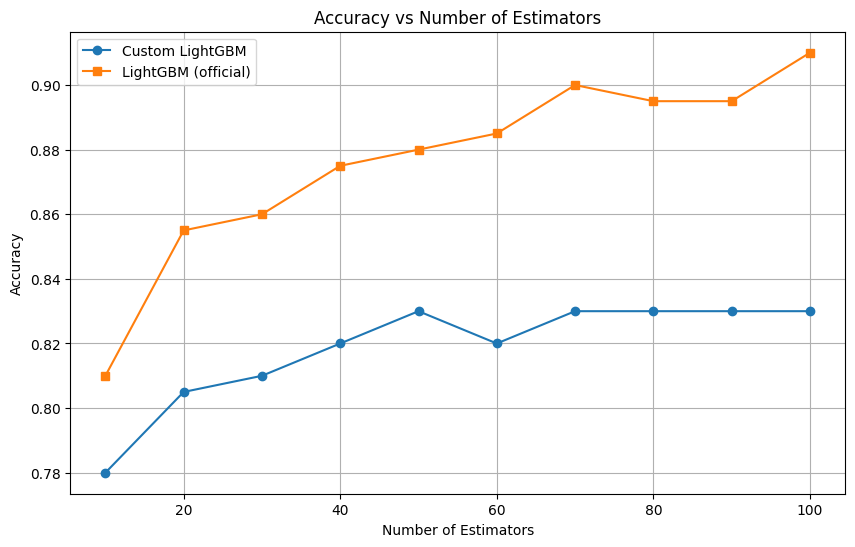

In [8]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15,
                           n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Сравнение моделей ===
custom_scores = []
lgbm_scores = []
estimators_range = range(10, 101, 10)

for n in estimators_range:
    # Custom LightGBM
    custom_model = LightGBMClassifier(n_estimators=n, learning_rate=0.1, max_depth=3)
    custom_model.fit(X_train, y_train)
    y_pred_custom = custom_model.predict(X_test)
    acc_custom = accuracy_score(y_test, y_pred_custom)
    custom_scores.append(acc_custom)

    # LightGBM (официальный)
    lgbm_model = LGBMClassifier(n_estimators=n, learning_rate=0.1, max_depth=3)
    lgbm_model.fit(X_train, y_train)
    y_pred_lgbm = lgbm_model.predict(X_test)
    acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
    lgbm_scores.append(acc_lgbm)

# === Визуализация ===
plt.figure(figsize=(10, 6))
plt.plot(estimators_range, custom_scores, label="Custom LightGBM", marker="o")
plt.plot(estimators_range, lgbm_scores, label="LightGBM (official)", marker="s")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Estimators")
plt.legend()
plt.grid(True)
plt.show()

# Это была сильно упрощенная модель, а я хочу полсностью со всеми преимуществами сделать

In [21]:
import numpy as np
from collections import defaultdict
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from scipy.special import expit

class CustomLightGBMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, 
                 learning_rate=0.1, 
                 n_estimators=100, 
                 max_depth=3, 
                 num_leaves=31, 
                 min_data_in_leaf=20, 
                 max_bins=255):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.num_leaves = num_leaves
        self.min_data_in_leaf = min_data_in_leaf
        self.max_bins = max_bins
        self.trees = []

    def _log_odds(self, p):
        return np.log(p / (1 - p))

    def _compute_gradients_and_hessians(self, y_true, y_pred):
        pred = expit(y_pred)
        grad = pred - y_true
        hess = pred * (1 - pred)
        return grad, hess

    def _bin_data(self, X):
        binned_X = np.zeros_like(X, dtype=np.uint8)
        self.bin_edges_ = []
        for j in range(X.shape[1]):
            col = X[:, j]
            edges = np.histogram_bin_edges(col, bins=self.max_bins)
            binned = np.digitize(col, edges) - 1
            binned = np.clip(binned, 0, self.max_bins - 1)
            binned_X[:, j] = binned
            self.bin_edges_.append(edges)
        return binned_X

    def fit(self, X, y):
        y = y.astype(int)
        n_samples, n_features = X.shape
        self.init_score_ = self._log_odds(np.mean(y))
        raw_scores = np.full(n_samples, self.init_score_)
        X_binned = self._bin_data(X)

        for m in range(self.n_estimators):
            grad, hess = self._compute_gradients_and_hessians(y, raw_scores)
            tree = self._fit_leaf_wise_tree(X_binned, grad, hess)
            self.trees.append(tree)
            pred = tree.predict(X_binned)
            # FIX: Changed from -= to += (critical!)
            raw_scores += self.learning_rate * pred

    def _fit_leaf_wise_tree(self, X, grad, hess):
        # Train tree to approximate negative gradient (anti-gradient)
        reg = DecisionTreeRegressor(
            max_depth=self.max_depth,
            max_leaf_nodes=self.num_leaves,
            min_samples_leaf=self.min_data_in_leaf,
        )
        reg.fit(X, -grad)  # Fit on anti-gradient
        
        # Get leaf indices for each sample
        leaf_ids = reg.apply(X)
        
        # Map leaves to sample indices
        node_to_indices = defaultdict(list)
        for i, node_id in enumerate(leaf_ids):
            node_to_indices[node_id].append(i)
        
        # Replace leaf values with optimized values
        tree_struct = reg.tree_
        for node_id in range(tree_struct.node_count):
            if tree_struct.children_left[node_id] == tree_struct.children_right[node_id]:  # Leaf node
                sample_indices = node_to_indices.get(node_id, [])
                if len(sample_indices) > 0:
                    G = np.sum(grad[sample_indices])
                    H = np.sum(hess[sample_indices]) + 1e-10  # Avoid division by zero
                    new_value = -G / H  # Optimized leaf value
                else:
                    new_value = 0.0
                tree_struct.value[node_id, 0, 0] = new_value
                
        return reg

    def predict_proba(self, X):
        X_binned = np.zeros_like(X, dtype=np.uint8)
        for j in range(X.shape[1]):
            edges = self.bin_edges_[j]
            binned = np.digitize(X[:, j], edges) - 1
            binned = np.clip(binned, 0, self.max_bins - 1)
            X_binned[:, j] = binned

        raw_scores = np.full(X.shape[0], self.init_score_)
        for tree in self.trees:
            raw_scores += self.learning_rate * tree.predict(X_binned)  # FIX: Changed to +=

        proba = expit(raw_scores)
        return np.vstack([1 - proba, proba]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

In [22]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

# Данные
X, y = make_classification(n_samples=3000, n_features=20, n_informative=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Custom LightGBM
clf_custom = CustomLightGBMClassifier(n_estimators=100)
clf_custom.fit(X_train, y_train)
y_pred_custom = clf_custom.predict(X_test)

# LightGBM от библиотеки
clf_lgb = LGBMClassifier(n_estimators=100)
clf_lgb.fit(X_train, y_train)
y_pred_lgb = clf_lgb.predict(X_test)

# Accuracy
print("Accuracy (Custom LightGBM):", accuracy_score(y_test, y_pred_custom))
print("Accuracy (LGBMClassifier): ", accuracy_score(y_test, y_pred_lgb))


[LightGBM] [Info] Number of positive: 1052, number of negative: 1048
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2100, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500952 -> initscore=0.003810
[LightGBM] [Info] Start training from score 0.003810
Accuracy (Custom LightGBM): 0.9188888888888889
Accuracy (LGBMClassifier):  0.94


[LightGBM] [Info] Number of positive: 1052, number of negative: 1048
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2100, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500952 -> initscore=0.003810
[LightGBM] [Info] Start training from score 0.003810
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

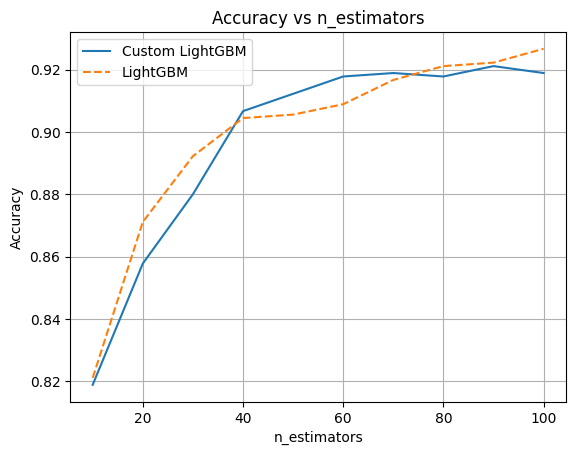

In [24]:
estimators_range = range(10, 110, 10)
accs_custom, accs_lgb = [], []

for n in estimators_range:
    # кастомная модель
    model_custom = CustomLightGBMClassifier(n_estimators=n, learning_rate=0.1, max_depth=3)
    model_custom.fit(X_train, y_train)
    accs_custom.append(accuracy_score(y_test, model_custom.predict(X_test)))

    # LightGBM
    model_lgb = LGBMClassifier(n_estimators=n, learning_rate=0.1, max_depth=3)
    model_lgb.fit(X_train, y_train)
    accs_lgb.append(accuracy_score(y_test, model_lgb.predict(X_test)))

plt.plot(estimators_range, accs_custom, label="Custom LightGBM")
plt.plot(estimators_range, accs_lgb, label="LightGBM", linestyle="--")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs n_estimators")
plt.legend()
plt.grid(True)
plt.show()


# Отлично, тперь вышло

# Преимущества и недостатки LightGBM
### Преимущества:
* высокая точность прогнозов и особенно скорость обучения;
* возможность работы с категориальными признаками;
* большое количество гиперпараметров для настройки алгоритма;
* применяется для многих задач.
### Недостатки:
* возможна нестабильная работа на датасетах небольшого размера;
* сложность в конфигурации из-за большого количества гиперпараметров.